In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [ ]:
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_train = x_train.reshape(-1, 784)
x_train = (x_train > 0.5).astype(np.float32)  # Binarize for RBM

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.lr = learning_rate

        self.W = np.random.randn(n_visible, n_hidden) * 0.01
        self.b = np.zeros(n_visible)  # bias for visible
        self.c = np.zeros(n_hidden)  # bias for hidden

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def sample_prob(self, probs):
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def contrastive_divergence(self, v0):
        # Positive phase
        h_prob = self.sigmoid(np.dot(v0, self.W) + self.c)
        h_sample = self.sample_prob(h_prob)

        # Negative phase
        v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.b)
        v_sample = self.sample_prob(v_prob)
        h_recon = self.sigmoid(np.dot(v_sample, self.W) + self.c)

        # Update weights
        self.W += self.lr * (np.dot(v0.T, h_prob) - np.dot(v_sample.T, h_recon)) / v0.shape[0]
        self.b += self.lr * np.mean(v0 - v_sample, axis=0)
        self.c += self.lr * np.mean(h_prob - h_recon, axis=0)

        loss = np.mean((v0 - v_prob)**2)
        return loss

    def reconstruct(self, v):
        h = self.sigmoid(np.dot(v, self.W) + self.c)
        v_recon = self.sigmoid(np.dot(h, self.W.T) + self.b)
        return v_recon

In [ ]:
rbm = RBM(n_visible=784, n_hidden=64, learning_rate=0.1)

epochs = 5
batch_size = 64

for epoch in range(epochs):
    np.random.shuffle(x_train)
    losses = []

    for i in range(0, x_train.shape[0], batch_size):
        batch = x_train[i:i+batch_size]
        loss = rbm.contrastive_divergence(batch)
        losses.append(loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}")

Epoch 1/5, Loss: 0.0536
Epoch 2/5, Loss: 0.0406
Epoch 3/5, Loss: 0.0378
Epoch 4/5, Loss: 0.0363
Epoch 5/5, Loss: 0.0354


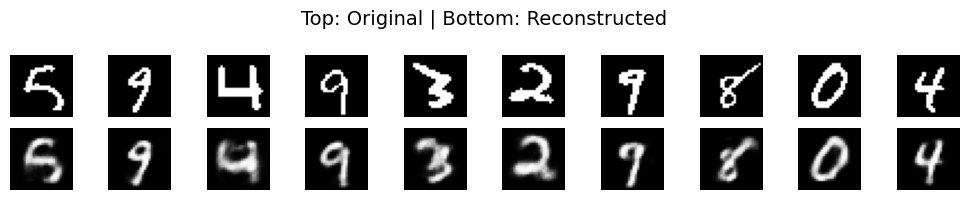

In [ ]:
sample_data = x_train[:10]
reconstructions = rbm.reconstruct(sample_data)

plt.figure(figsize=(10, 2))
for i in range(10):
    # Original
    plt.subplot(2, 10, i+1)
    plt.imshow(sample_data[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    # Reconstructed
    plt.subplot(2, 10, i+11)
    plt.imshow(reconstructions[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Top: Original | Bottom: Reconstructed", fontsize=14)
plt.tight_layout()
plt.show()